# Weather analysis from [CEPAGRI](http://www.cpa.unicamp.br/)<sup>[1](#fn1)</sup>

## Imports

In [33]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
plt.rcParams['figure.figsize'] = [19, 9]
import datetime

## Load file

In [2]:
file_handler = 'cepagri.csv'
#url = 'http://www.ic.unicamp.br/~zanoni/cepagri/' + file_handler
#r = requests.get(url, allow_redirects=True)
#open('data/' + file_handler, 'wb').write(r.content)

In [3]:
data = pd.read_csv('data/' + file_handler, sep=';', index_col=False)

C:\Users\suzan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.columns = ['date', 'temperature', 'wind', 'humidity', 'sensation']

In [5]:
data.head()

,date,temperature,wind,humidity,sensation
0,02/03/2014-19:18,23.4,59.1,77.9,22.3
1,02/03/2014-19:28,23.2,56.7,78.9,22.1
2,02/03/2014-19:38,23.0,55.4,79.2,21.9
3,02/03/2014-19:48,22.8,52.6,79.7,21.7
4,02/03/2014-19:58,22.6,62.6,80.7,21.5


## Data cleaning

First, we'll deal with `na`values. Let's simple remove it

In [6]:
data.isnull().values.any()

True

In [7]:
data.isnull().sum()

date              0
temperature       0
wind           2324
humidity       2324
sensation      2324
dtype: int64

In [8]:
data = data.dropna()

In [9]:
data.describe()

,wind,humidity,sensation
count,294781.000000,294781.000000,294781.000000
mean,28.989507,70.049357,19.505640
std,15.779359,19.184172,6.407524
min,0.000000,0.000000,-8.200000
25%,17.300000,56.800000,16.100000
50%,25.000000,73.200000,19.800000
75%,38.400000,85.200000,23.800000
max,143.600000,100.000000,99.900000


Now, let's remove spurious data.

In [10]:
data = data[data.sensation != 99.9]

In [11]:
data.dtypes

date            object
temperature     object
wind           float64
humidity       float64
sensation      float64
dtype: object

In [12]:
data.date = pd.to_datetime(data.date, format='%d/%m/%Y-%H:%M')
data.temperature = pd.to_numeric(data.temperature, errors='coerce')
data['year_month'] = data['date'].apply(lambda s: datetime.date(s.year, s.month, 1))
data.year_month = pd.to_datetime(data['year_month'], errors='coerce') #data.year_month.astype('str')

In [13]:
data.dtypes

date           datetime64[ns]
temperature           float64
wind                  float64
humidity              float64
sensation             float64
year_month     datetime64[ns]
dtype: object

In [14]:
data = data.loc[(data.date < '2018-01-01') & (data.date >= '2015-1-1')]

In [15]:
data

,date,temperature,wind,humidity,sensation,year_month
42081,2015-01-01 00:00:00,22.7,22.2,92.2,21.6,2015-01-01
42083,2015-01-01 00:20:00,22.6,23.1,92.5,21.5,2015-01-01
42084,2015-01-01 00:30:00,22.7,23.1,92.0,21.6,2015-01-01
42085,2015-01-01 00:40:00,22.8,22.7,91.3,21.7,2015-01-01
42086,2015-01-01 00:50:00,22.7,22.3,91.6,21.6,2015-01-01
...,...,...,...,...,...,...
198134,2017-12-31 23:10:00,21.1,18.2,84.6,19.9,2017-12-01
198135,2017-12-31 23:20:00,21.1,20.2,84.7,19.9,2017-12-01
198136,2017-12-31 23:30:00,21.0,22.5,84.8,19.9,2017-12-01
198137,2017-12-31 23:40:00,21.0,18.4,84.8,19.8,2017-12-01


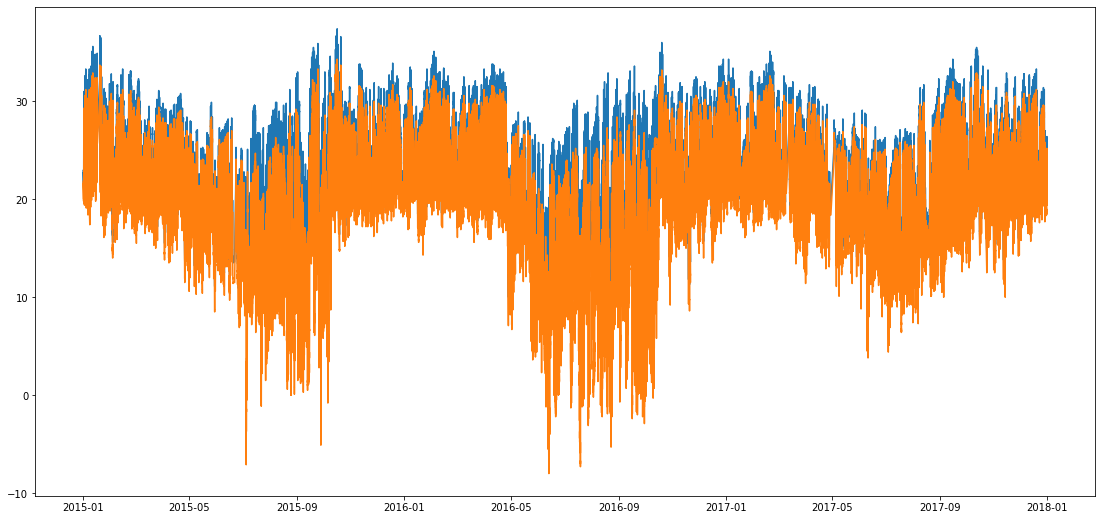

In [20]:
plt.plot(data.date, data.temperature)
plt.plot(data.date, data.sensation)

## Psychrometrics analysis

Based on [[2]](#fn2), we have: 

| Relative Humidity (in %) | State |
|--------------------------|-----------|
| 0 to 11.9 | Emergency |
| 12 to 19.9 | Alert |
| 20 to 29.9 | Attention |

Let's display the frequency of days with these characteristics:

In [21]:
data['humidity_level'] = 'NORMAL'
data.loc[data['humidity'] < 30, 'humidity_level'] = 'WARNING'
data.loc[data['humidity'] < 20, 'humidity_level'] = 'ALERT'
data.loc[data['humidity'] < 12, 'humidity_level'] = 'EMERGENCY'
data.humidity_level = data.humidity_level.astype('category')

In [22]:
num_categories = len(set(data['humidity_level']))
colors = [cmx.autumn(float(i)/num_categories) for i in data.humidity_level.cat.codes]

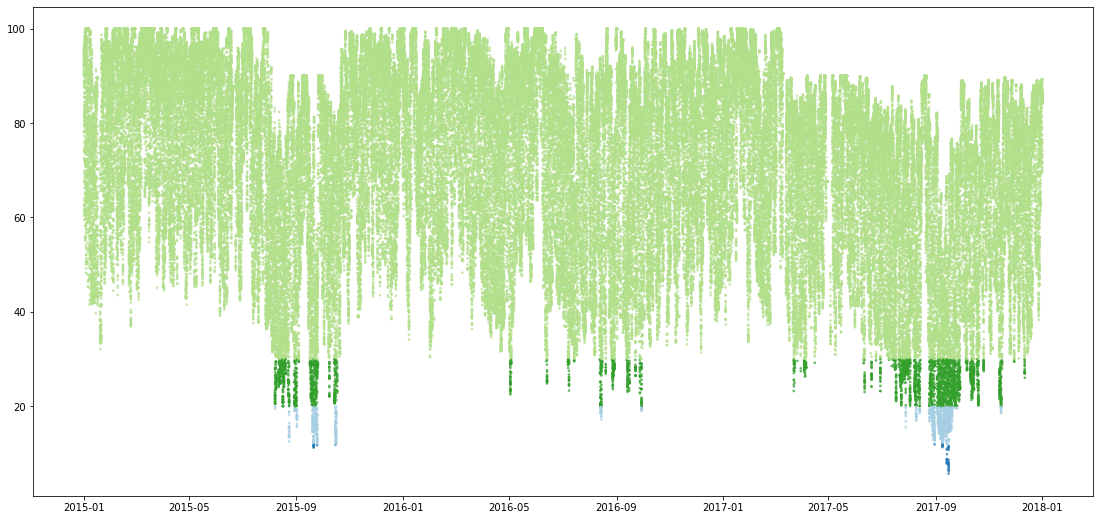

In [23]:
plt.scatter('date', 'humidity', data = data, c = cmx.Paired(data.humidity_level.cat.codes), alpha = .6, s = 3)

## Beaufort scale

| Degree |     Label      | Velocity(km/h) |
| :--- | :-----------------: | ---------------: |
| 0    |        Calm         | <1              |
| 1    |       Light air     | 1 a 5            |
| 2    |     Light breeze    | 6 a 11           |
| 3    |     Gentle breeze	 | 12 a 19          |
| 4    |   Moderate breeze   | 20 a 28          |
| 5    |     Fresh breeze    | 29 a 38          |
| 6    |    Strong breeze    | 39 a 49          |
| 7    |     High wind       | 50 a 61          |
| 8    |      Fresh gale     | 62 a 74          |
| 9    | Strong/severe gale	 | 75 a 88          |
| 10   |     Storm           | 89 a 102         |
| 11   | Violent Storm       | 103 a 117        |
| 12   |   Hurricane force   | \>118            |

In [39]:
beaufort_categories=['CALM', 'LIGHT_AIR', 'LIGHT_BREEZE', 'GENTLE_BREEZE', 'MODERATE_BREEZE', 'FRESH_BREEZE',
                                              'STRONG_BREEZE', 'HIGH_WIND', 'FRESH_GALE', 'STRONG_SEVERE_GALE', 'STORM', 'VIOLENT_STORM']
beaufort_scale = CategoricalDtype(categories=beaufort_categories, ordered=True)
data['beaufort_scale'] = 'HURRICANE_FORCE'
data.loc[data['wind'] < 118, 'beaufort_scale'] = 'VIOLENT_STORM'
data.loc[data['wind'] < 103, 'beaufort_scale'] = 'STORM'
data.loc[data['wind'] < 89, 'beaufort_scale'] = 'STRONG_SEVERE_GALE'
data.loc[data['wind'] < 75, 'beaufort_scale'] = 'FRESH_GALE'
data.loc[data['wind'] < 62, 'beaufort_scale'] = 'HIGH_WIND'
data.loc[data['wind'] < 50, 'beaufort_scale'] = 'STRONG_BREEZE'
data.loc[data['wind'] < 39, 'beaufort_scale'] = 'FRESH_BREEZE'
data.loc[data['wind'] < 29, 'beaufort_scale'] = 'MODERATE_BREEZE'
data.loc[data['wind'] < 20, 'beaufort_scale'] = 'GENTLE_BREEZE'
data.loc[data['wind'] < 12, 'beaufort_scale'] = 'LIGHT_BREEZE'
data.loc[data['wind'] < 6, 'beaufort_scale'] = 'LIGHT_AIR'
data.loc[data['wind'] < 1, 'beaufort_scale'] = 'CALM'
data.beaufort_scale = data.beaufort_scale.astype(beaufort_scale)

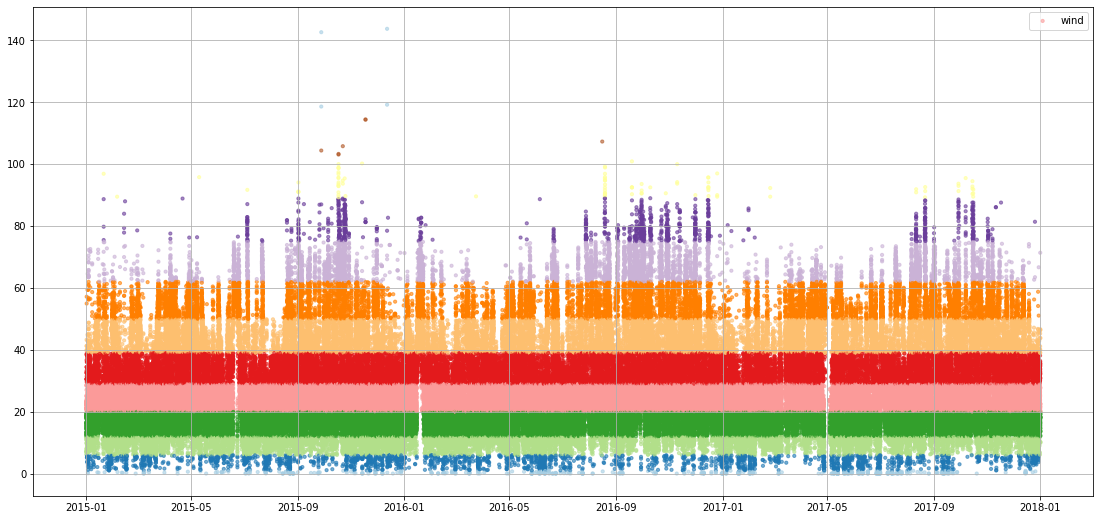

In [40]:
plt.scatter('date', 'wind', data = data, c = cmx.Paired(data.beaufort_scale.cat.codes), alpha = .6, s = 10)
#            label = set(data.beaufort_scale.cat.categories))
plt.legend()
plt.grid(True)
plt.show()

In [41]:
data.head()

,date,temperature,wind,humidity,sensation,year_month,humidity_level,beaufort_scale
42081,2015-01-01 00:00:00,22.7,22.2,92.2,21.6,2015-01-01,NORMAL,MODERATE_BREEZE
42083,2015-01-01 00:20:00,22.6,23.1,92.5,21.5,2015-01-01,NORMAL,MODERATE_BREEZE
42084,2015-01-01 00:30:00,22.7,23.1,92.0,21.6,2015-01-01,NORMAL,MODERATE_BREEZE
42085,2015-01-01 00:40:00,22.8,22.7,91.3,21.7,2015-01-01,NORMAL,MODERATE_BREEZE
42086,2015-01-01 00:50:00,22.7,22.3,91.6,21.6,2015-01-01,NORMAL,MODERATE_BREEZE


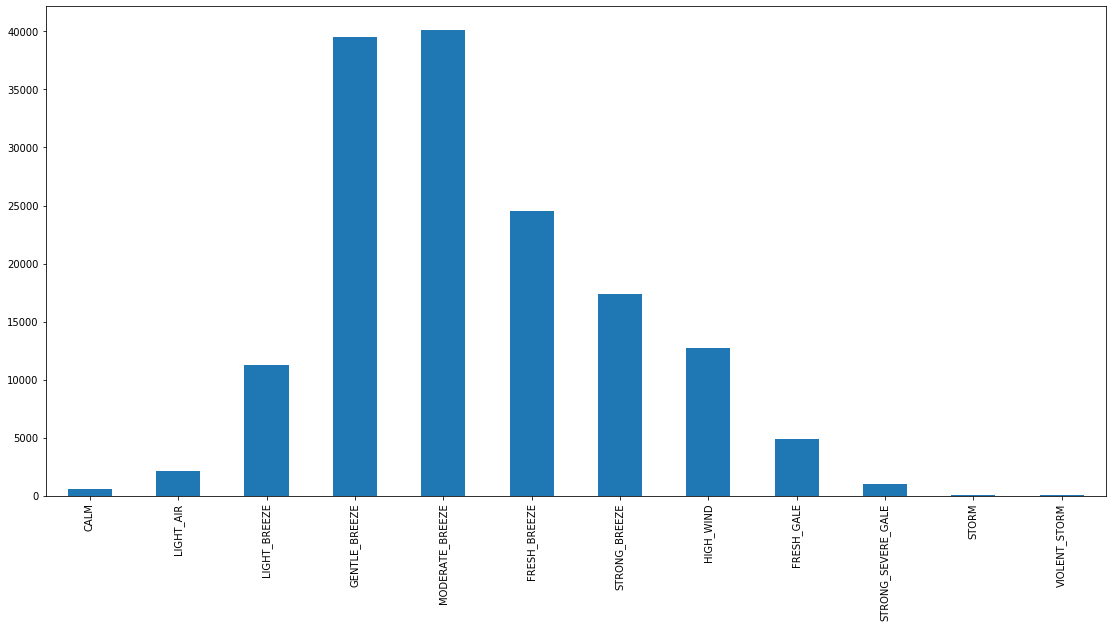

In [48]:
data.beaufort_scale.value_counts().reindex(beaufort_categories).plot(kind = 'bar')

In [28]:
per = data.year_month.dt.to_period("M")
g = data.groupby(per)

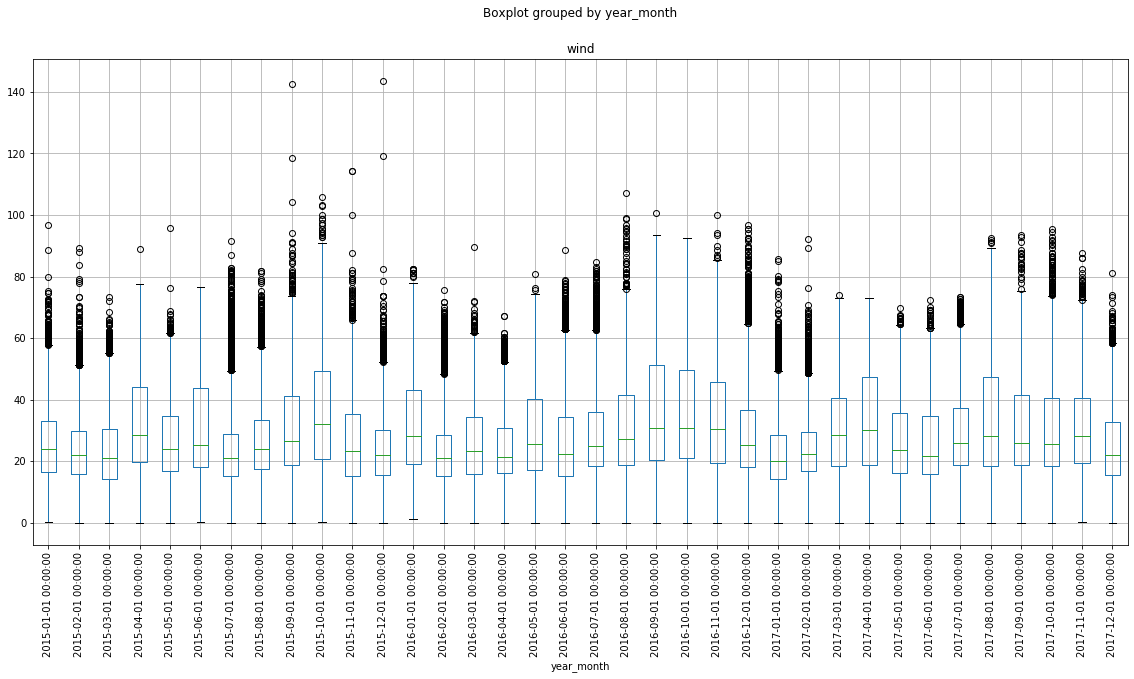

In [29]:
data.boxplot(column=['wind'], by = 'year_month', rot=90)

## Correlations

In [52]:
data.corr()

,temperature,wind,humidity,sensation
temperature,1.000000,-0.171136,-0.626365,0.904353
wind,-0.171136,1.000000,0.006064,-0.271492
humidity,-0.626365,0.006064,1.000000,-0.467967
sensation,0.904353,-0.271492,-0.467967,1.000000


This evaluations shows that `temperature` and `sensation` are strongly related. Let's see the two charts together:

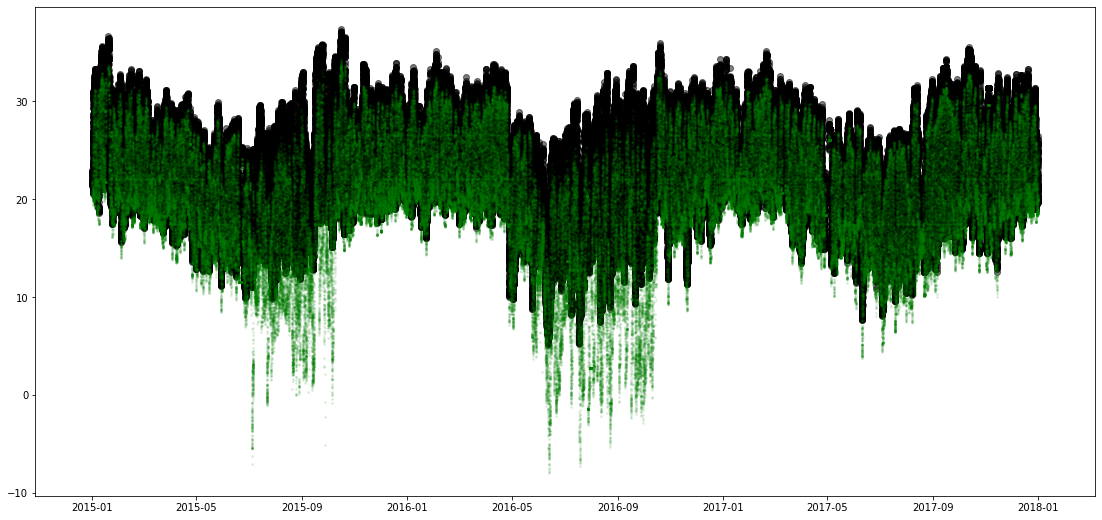

In [62]:
plt.scatter(data.date, data.temperature, color='k', alpha=.5)
plt.scatter(data.date, data.sensation, color='g', s=3, alpha=.1)
plt.show()

----

## References
* https://matplotlib.org/examples/color/colormaps_reference.html
* https://towardsdatascience.com/an-end-to-end-project-on-time-series-analysis-and-forecasting-with-python-4835e6bf050b
* https://pandas.pydata.org/pandas-docs/stable/user_guide/reshaping.html

----
## Notes

<a name="fn1">1</a>: Centro de Pesquisas Meteorológicas e Climáticas Aplicadas à Agricultura. Está instalado no prédio da Embrapa Infomática Agropecuária, localizado no Campus da UNICAMP

<a name="fn2">2</a>: https://www.cgesp.org/v3/umidade-relativa-do-ar.jsp